## En este codigo hago las predicciones para las redes Densas (sin PCA) y CNN.

Importacion de librerias:

In [20]:
import tensorflow as tf
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from scipy.fft import fft, ifft
import math
import scipy.special
from scipy.stats import poisson
from tensorflow.keras.models import load_model

Carga de datos que uso para predecir (del 1 al 4 use para conseguir los datos de entrenamientos):

In [21]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["CH1"]
PHOT = pd.read_csv("5.Wfm.csv", sep=";")
PHOT.columns = columns
PHOT = -PHOT

Visualizacion de los datos crudos:

Text(0, 0.5, 'Tension [V]')

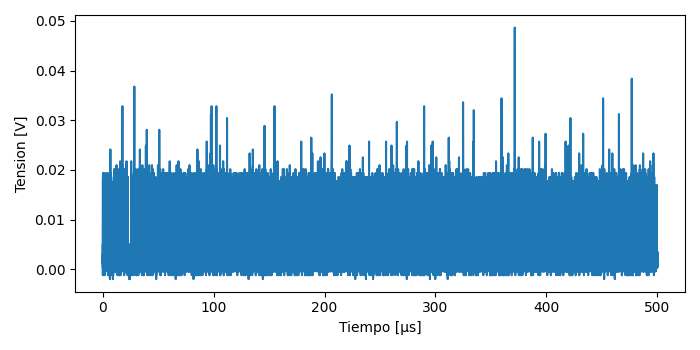

In [22]:
%matplotlib widget
tmin = 0 # MICROSEGUNDOS
tmax = 500 # MICROSEGUNDOS
num_samples = len(PHOT.CH1)
tt = tmax-tmin

time = np.linspace(tmin, tmax, num_samples)

plt.figure()
plt.plot(time, PHOT.CH1)
plt.xlabel("Tiempo [µs]")
plt.ylabel("Tension [V]")

Aca separo los pulsos y los guardo en el array VecPulses[], esto es simplemente poner un threshold que indica que hay un foton. Si no supero el threshold, avanzo un punto, si lo encuentro, avanzo 50 ns (50 puntos) que corresponde al tiempo de respuesta del MPPC y donde se supone que no deberia haber otro foton, salvo en el caso de AfterPulse.

1 Gsample/s -> 1 ns = 1 sample

In [23]:
num_puntos = 60
punto_final = 50 #50 ns de tiempo de respuesta
threshold_1foton = 0.013

VecPulses = np.zeros((0,num_puntos))
Pulse = np.zeros(num_puntos)
k = 0
i = 100
while i< PHOT.size-500:
    if PHOT.CH1[i] > threshold_1foton:
        k=k+1
        for j in range(num_puntos):
            Pulse[j] = PHOT.CH1[i+j-(num_puntos-punto_final)]
        VecPulses = np.append(VecPulses, Pulse)
        VecPulses = VecPulses.reshape((k,num_puntos))
        i = i+punto_final
        
        continue
    else:
        i += 1
        continue

Visualizacion de los distintos pulsos guardados en VecPulses.

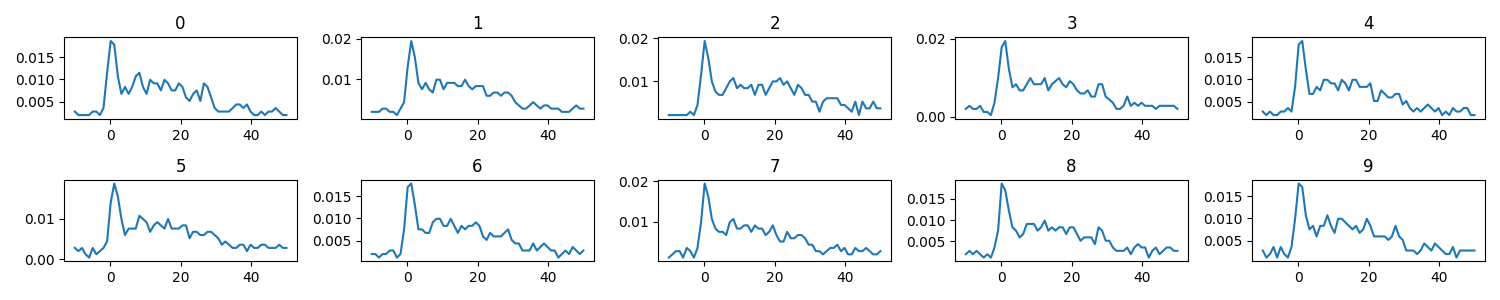

In [24]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, VecPulses[l])
    plt.title(l)

Cargo el modelo Denso:

In [25]:
model = load_model("model_dense.h5")

Hago las predicciones de pulsos dobles y afterpulses, y los guardo para poder visualizarlos. Tambien guardo cuantos hay.

In [45]:
double_count = 0
after_count = 0
after_pulsos_dense = np.ndarray((100,60))
double_pulsos_dense = np.ndarray((100,60))
for j in range(VecPulses.shape[0]):
    input_data = VecPulses[j].reshape((1,num_puntos))
    predictions = model.predict(input_data, verbose = 0)
    if (np.argmax(predictions) == 1 and np.max(predictions) > 0.9): 
        after_pulsos_dense[after_count] = VecPulses[j]
        print("El pulso " + str(j)+" es un afterpulse.")
        after_count = after_count + 1
    if (np.argmax(predictions) == 2 and np.max(predictions) > 0.9): 
        print("El pulso " + str(j)+" es un doble pulso.")
        double_pulsos_dense[double_count] = VecPulses[j]
        double_count = double_count+1

El pulso 20 es un afterpulse.
El pulso 44 es un afterpulse.
El pulso 49 es un doble pulso.
El pulso 78 es un doble pulso.
El pulso 89 es un afterpulse.
El pulso 106 es un afterpulse.
El pulso 109 es un afterpulse.
El pulso 128 es un afterpulse.
El pulso 153 es un afterpulse.
El pulso 167 es un afterpulse.
El pulso 171 es un afterpulse.
El pulso 212 es un afterpulse.
El pulso 243 es un afterpulse.
El pulso 254 es un afterpulse.
El pulso 255 es un doble pulso.
El pulso 257 es un doble pulso.
El pulso 263 es un afterpulse.
El pulso 275 es un doble pulso.
El pulso 284 es un afterpulse.
El pulso 304 es un doble pulso.
El pulso 368 es un afterpulse.
El pulso 375 es un afterpulse.
El pulso 403 es un doble pulso.
El pulso 428 es un doble pulso.
El pulso 486 es un afterpulse.
El pulso 510 es un doble pulso.
El pulso 518 es un afterpulse.
El pulso 532 es un afterpulse.
El pulso 547 es un afterpulse.
El pulso 560 es un doble pulso.
El pulso 561 es un afterpulse.
El pulso 595 es un afterpulse.
El 

In [46]:
print("Dobles: " + str(double_count) +"/"+str(VecPulses.shape[0]))
print("Afters: " + str(after_count) +"/"+str(VecPulses.shape[0]))

Dobles: 23/1282
Afters: 55/1282


Aca los puedo ver

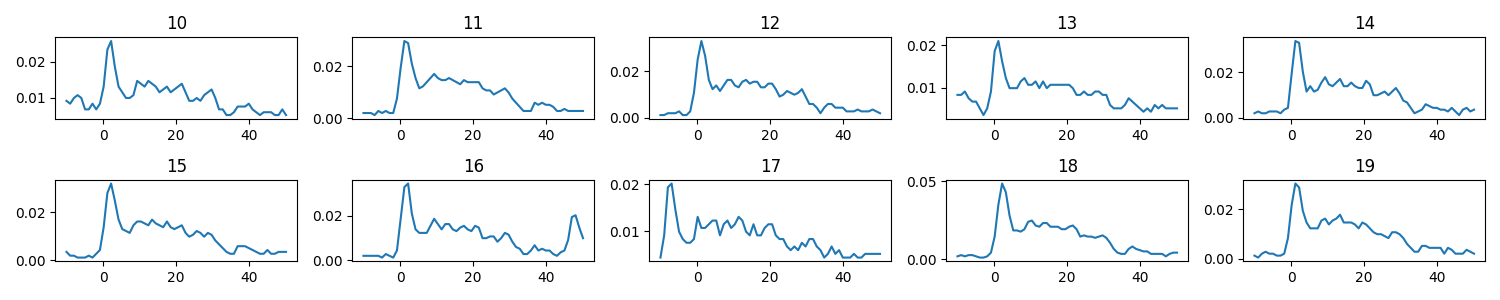

In [63]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 1
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, double_pulsos_dense[l])
    plt.title(l)

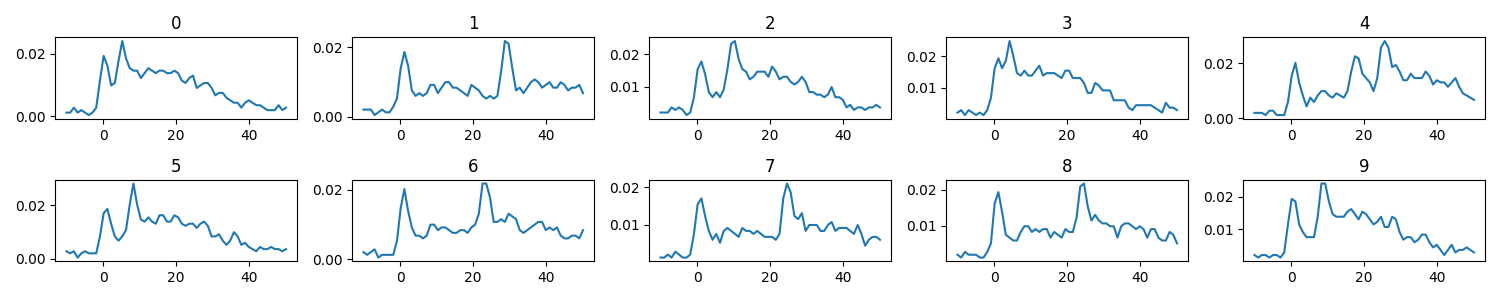

In [52]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, after_pulsos_dense[l])
    plt.title(l)

Cargo el modelo convolucional:

In [53]:
model_cnn = load_model("model_cnn.h5")

In [54]:
double_count = 0
after_count = 0
after_pulsos_cnn = np.ndarray((100,60))
double_pulsos_cnn = np.ndarray((100,60))
for j in range(VecPulses.shape[0]):
    input_data = VecPulses[j].reshape((1,num_puntos))
    predictions = model_cnn.predict(input_data, verbose = 0)
    if (np.argmax(predictions) == 1): 
        after_pulsos_cnn[after_count] = VecPulses[j]
        print("El pulso " + str(j)+" es un afterpulse.")
        after_count = after_count + 1
    if (np.argmax(predictions) == 2): 
        print("El pulso " + str(j)+" es un doble pulso.")
        double_pulsos_cnn[double_count] = VecPulses[j]
        double_count = double_count+1

El pulso 20 es un afterpulse.
El pulso 44 es un afterpulse.
El pulso 49 es un doble pulso.
El pulso 69 es un afterpulse.
El pulso 70 es un doble pulso.
El pulso 71 es un afterpulse.
El pulso 78 es un doble pulso.
El pulso 89 es un afterpulse.
El pulso 106 es un afterpulse.
El pulso 109 es un afterpulse.
El pulso 128 es un afterpulse.
El pulso 153 es un afterpulse.
El pulso 167 es un afterpulse.
El pulso 171 es un afterpulse.
El pulso 212 es un afterpulse.
El pulso 213 es un doble pulso.
El pulso 243 es un afterpulse.
El pulso 254 es un afterpulse.
El pulso 255 es un doble pulso.
El pulso 257 es un doble pulso.
El pulso 263 es un afterpulse.
El pulso 275 es un doble pulso.
El pulso 284 es un afterpulse.
El pulso 304 es un doble pulso.
El pulso 368 es un afterpulse.
El pulso 375 es un afterpulse.
El pulso 376 es un doble pulso.
El pulso 403 es un doble pulso.
El pulso 428 es un doble pulso.
El pulso 486 es un afterpulse.
El pulso 509 es un afterpulse.
El pulso 510 es un doble pulso.
El p

In [55]:
print("Dobles: " + str(double_count) +"/"+str(VecPulses.shape[0]))
print("Afters: " + str(after_count) +"/"+str(VecPulses.shape[0]))

Dobles: 28/1282
Afters: 60/1282


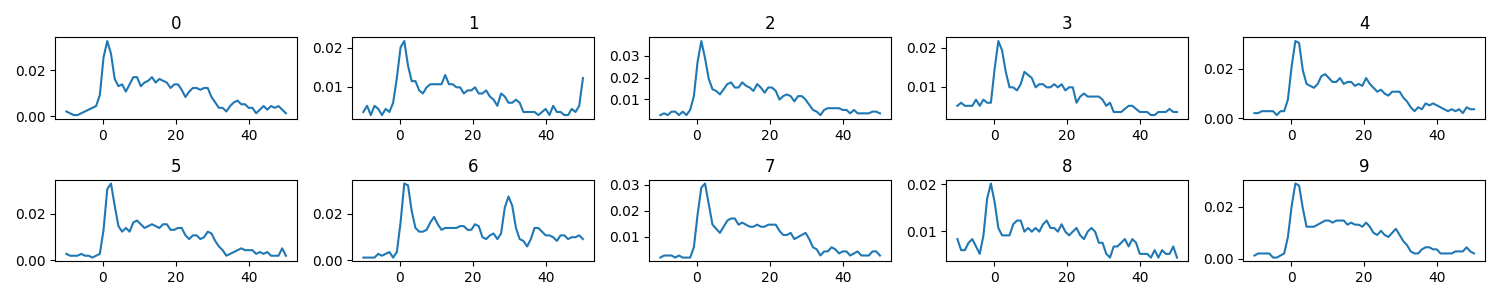

In [58]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, double_pulsos_cnn[l])
    plt.title(l)

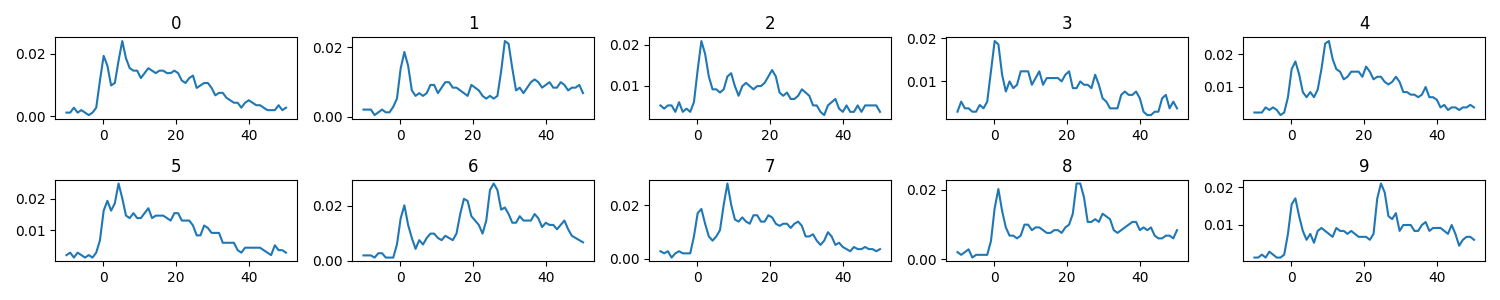

In [60]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, after_pulsos_cnn[l])
    plt.title(l)